# Setup Environment

## Load Python Modules

In [13]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_recall_fscore_support
# import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch
import matplotlib.pyplot as plt
import os
from data_loader import *
import util
from CNN import *
from copy import deepcopy
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Show NVIDIA GPU

In [3]:
!nvidia-smi -L

GPU 0: NVIDIA H200 (UUID: GPU-2fb8e130-a6b9-3233-8a3e-f625e7fe1bbc)


## Setup utility

In [4]:
util.setup_logger()

# Load and Process Dataset

## Load Dataset (Embedded split, workaround)

In [15]:
folder_path = "/mnt/dataset"
_all_dataset = data_loader(os.path.join(folder_path, "feature"), os.path.join(folder_path, "label"))
_files = _all_dataset.file_names
train_files, valid_files = train_test_split(_files, test_size=.2)
valid_files, test_files = train_test_split(valid_files, test_size=.5)
train_dataset = deepcopy(_all_dataset)
train_dataset.file_names = train_files
valid_dataset = deepcopy(_all_dataset)
valid_dataset.file_names = valid_files
test_dataset = deepcopy(_all_dataset)
test_dataset.file_names = test_files

logging.info(f"{len(train_dataset)} images for train, {len(valid_dataset)} for validation, and {len(test_dataset)} for testing")

[INFO] 8193 images for train, 1024 for validation, and 1025 for testing


## Load Dataset (Hard split, ideal but not ready)

In [29]:
# folder_path = os.path.join(os.getenv("HOME"), "scratch")
folder_path = "./dataset/small"
valid_dir = "./dataset/validation"
train_dataset = data_loader(os.path.join(folder_path, "feature"), os.path.join(folder_path, "label"))
valid_dataset = data_loader(os.path.join(valid_dir, "feature"), os.path.join(valid_dir, "label"))
# test_dataset  = ImageDataset(os.path.join(folder_path, "test_10p.csv"), use_augmentation=False)

In [16]:
train_dataset.check()

AssertionError: 

# CNN Model

## Create Torch Data Loaders

In [17]:
# train_loader, valid_loader, test_loader = dataset.get_loaders()
train_loader = train_dataset.get_torch_loader()
valid_loader = valid_dataset.get_torch_loader()
# test_loader  = test_dataset.get_loader()

## Check CUDA Availability

In [18]:
# "cuda" only when GPUs are available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Debug

In [19]:
path = os.path.join("/mnt/dataset", "feature")
print("Is symlink:", os.path.islink(path))
print("Exists:", os.path.exists(path))
print("Real path:", os.path.realpath(path))

Is symlink: False
Exists: True
Real path: /mnt/dataset/feature


In [21]:
print(os.getcwd())
file_name = "10000-zero-riscy-b-3-c2-u0.85-m1-p6-f1.npy"
# print(os.path.exists(os.path.join("dataset", "small", "feature")))
feature = np.load(os.path.join("./dataset/small", "feature", file_name))
label = np.load(os.path.join("./dataset/small", "label", file_name))
print(transforms.ToTensor()(feature).shape)
feature = np.transpose(feature, (2, 0, 1))
feature = np.expand_dims(feature, axis=0)

print(feature.shape)

model = CNN_FC()
tensor = torch.tensor(feature, dtype=torch.float32)
predict = model(tensor)
X_train, Y_train = train_dataset[0]
print(X_train.shape)
print(X_train.dtype, Y_train.dtype)
# predict = model(X_train)

/home/hice1/ctsai314/DL/Project
torch.Size([24, 256, 256])
(1, 24, 256, 256)
torch.Size([24, 256, 256])
torch.float32 torch.float32


In [22]:
for batch in train_loader:
    x, y = batch
print(x.shape, y.shape)
print(y.dtype)
print(x.dtype)
model = model.to(device)
predict = model(x.to(device))
loss = criterion(predict, y.to(device))

KeyboardInterrupt: 

## Training Setup

In [23]:
_exp_name = "CNN_0701"
# The number of training epochs and patience.
n_epochs = 100
patience = 30 # If no improvement in 'patience' epochs, early stop

# Initialize a model, and put it on the device specified.
model, train_losses, valid_losses = try_load_model(_exp_name)
if model == None:
    model = CNN_FC().to(device)

# For the classification task, we use cross-entropy as the measurement of performance.
# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()

# Initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=1e-5)

[INFO] Model loaded from CNN_0701_best.ckpt, loss loaded from CNN_0701_loss.pkl, trained for 5 epochs


## Training

In [ ]:
train_model(model, optimizer, train_loader, valid_loader, n_epochs=n_epochs, patience=patience,
            criterion=nn.MSELoss(), train_losses = train_losses, valid_losses = valid_losses,
            prefix = _exp_name)

100%|██████████| 32/32 [01:40<00:00,  3.13s/it]


[ Valid | 001/100 ] loss = 11.36930, acc = 0.17951
[ Valid | 001/100 ] loss = 11.36930, acc = 0.17951 -> best


  2%|▏         | 6/257 [00:20<13:01,  3.11s/it]

# Testing the Model

## Load the model

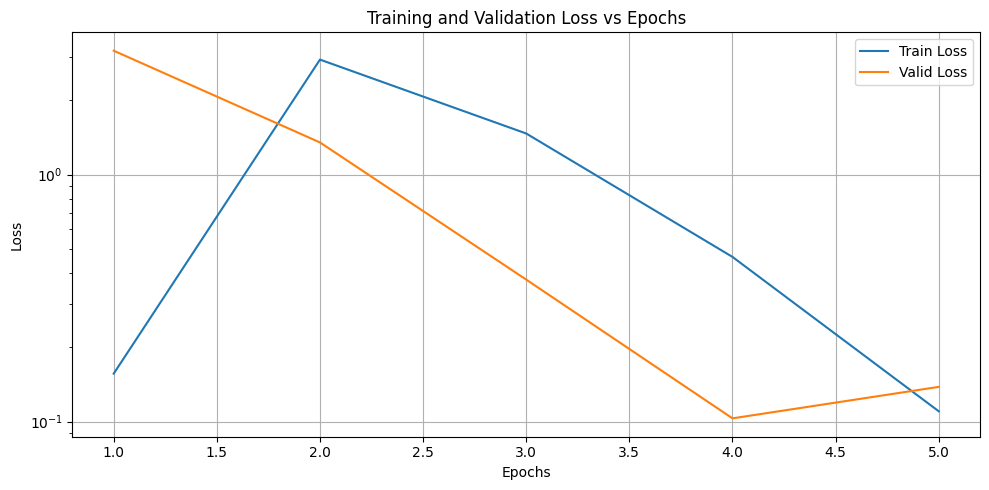

In [47]:
# model = load_model(f"{_exp_name}_best.ckpt")
model, train_losses, valid_losses = try_load_model(_exp_name)
plot_losses(train_losses, valid_losses)

## Evaluation

In [ ]:
# NOT READY.
evaluate_model(model, test_loader)